<a href="https://www.kaggle.com/code/jesusgraterol/bitcoin-trend-prediction-model-tensorflow?scriptVersionId=137273237" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bitcoin Trend Prediction Model

In this notebook, we build and train a Multi-Step / Multi-Output Regression Model powered by TensorFlow & Keras in order to predict Bitcoin's future trend. 

Even though a hyperparameter tuning mechanism is out of the scope of this notebook, we will be trying a series of networks such as: Dense, Convolutional with and without Max Pooling, Long Short-Term Memory (LSTM), Gated Recurrent Unit, etc.

The metrics we will be using to evaluate how well our model generalizes when predicting on unseen data are MAE (Mean Absolute Error) and MSE (Mean Squared Error). The Neural Network that scores the lowest loss is the one that should be deployed to production.

It is also important to mention that this model will be trained based on the moving averages as the Bitcoin's price is full of noise, and we don't want our model to learn useless patterns.

In [1]:
##################
## Dependencies ##
##################

from typing import Union, Literal, TypedDict, Optional, List, Tuple
from random import seed, randint
from numpy import ndarray, array, linspace
from numpy.random import seed as npseed
from pandas import options, DataFrame
from tensorflow import print as tfprint, random as tf_random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Reshape, Dense, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteErrorMetric, MeanSquaredError as MeanSquaredErrorMetric
from tensorflow.keras.callbacks import EarlyStopping, History
import utilities as utils
import matplotlib.pyplot as plt
options.display.float_format = '{:.6f}'.format

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.4 MB/s eta 0:00:00


In [2]:
###########
## Types ##
###########


# Optimizer
IOptimizerID = Literal["adam", "rmsprop", "sgd"]

# Learning Rate - Keep in mind that -1 stands for the Inverse Time Decay Learning Rate Schedule
ILearningRateID = Literal["0.01", "0.001", "0.0001", "-1"]

# Loss Function
ILossFunctionID = Literal["mean_absolute_error", "mean_squared_error"]

# The neural networks' idenfiers that can be used to build the model
INetworkID = Literal["Dense", "Conv1D", "MaxPooling1D", "LSTM", "BDLSTM", "GRU"]

# The neural networks' capacities that can be applied per layer
INetworkCapacity = Literal[2, 4, 8, 16, 32, 64, 128, 256, 512, 124]

# The activation functions that can be set on each layer
IActivationFunctionID = Literal["relu", "sigmoid", "softmax", "tanh"]

# The hidden layer dict that can be stacked and placed between the input and the output
class IHiddenLayer(TypedDict):
    type: INetworkID
    units: Optional[INetworkCapacity]
    filters: Optional[INetworkCapacity]
    kernel_size: Optional[Literal[3, 5]]
    activation: Optional[IActivationFunctionID]
    return_sequences: Optional[bool]

# Configuration
# The dictionary used to hold user input to prevent/limit the 
# editing of the source code.
class IConfig(TypedDict):
    ds_start: Union[int, str, None] = None
    ds_end: Union[int, str, None] = None
    candlesticks_interval: utils.IIntervalID
    sma_window_size: int
    train_split: float
    validation_split: float
    input_width: int
    output_width: int
    optimizer: IOptimizerID
    learning_rate: ILearningRateID
    loss_function: ILossFunctionID
    max_epochs: int
    early_stopping_patience: int
    batch_size: int
    shuffle_training_data: bool
    restore_best_weights: bool
    hidden_layers: List[IHiddenLayer]
    prediction_samples_limit: int

In [3]:
#############
## Globals ##
#############

# The random seed that will be set in order to make results reproducible
RANDOM_SEED: int = 60184
seed(RANDOM_SEED)
npseed(RANDOM_SEED)
tf_random.set_seed(RANDOM_SEED)

# Chart Sizes
SMALL_FIG_SIZE: Tuple[int, int] = (6, 4)
MEDIUM_FIG_SIZE: Tuple[int, int] = (9, 6)

# Configuration

In [4]:
CONFIG: IConfig = { 
    # The date range that will be covered in the dataset
    "ds_start": "01/01/2018", # DD/MM/YYYY
    "ds_end": None, # All the way to the end of the candlesticks' history
    
    # The candlesticks interval that will be used in the dataset
    "candlesticks_interval": "15m",
    
    # The window size that will be used when calculating the simple moving average (price normalization)
    "sma_window_size": 50,
    
    # The split that will be applied to the dataset to separate the training and evaluation data
    "train_split": 0.75,
    
    # The split that will be applied to the training data in order to fit the model
    "validation_split": 0.2,
    
    # The number of items that will be included in the input sequence. F.e: if the candlesticks_interval 
    # is set at 1h and the input_width is equals to 128, a total of 128 hours worth will be fed to the
    # model when predicting.
    "input_width": 128,
    
    # The number of items that will be predicted by the model.  F.e: if the candlesticks_interval is set 
    # at 1h and the output_width is equals to 32, a total of 32 hours will be predicted at a time.
    "output_width": 32,
    
    # The optimizer that will be attached to the model's instance
    "optimizer": "adam",
    
    # The rate of learning at which the optimizer will operate when training
    "learning_rate": "-1",
    
    # The loss function that will be used to train and evaluate the model
    "loss_function": "mean_absolute_error",
    
    # The maximum number of epochs the model can be trained for
    "max_epochs": 1000,
    
    # The maximum number of epochs the model can continue training for without improving
    "early_stopping_patience": 15,
    
    # The number of samples that will be propagated through the network while training (per step)
    "batch_size": 512,
    
    # If enabled, the training data will be shuffled so the model remains general and doesn't overfit on 
    # order based patterns
    "shuffle_training_data": True,
    
    # If enabled, the best state of the model will be set once it has finished training (lowest val_loss)
    "restore_best_weights": True,
    
    # The list of layers that will be inserted between the model's input & output layers
    "hidden_layers": [
        # CNN
        #{ "type": "Conv1D", "filters": 256, "kernel_size": 5, "activation": "relu" },
        #{ "type": "Conv1D", "filters": 128, "kernel_size": 3, "activation": "relu" },
        #{ "type": "Conv1D", "filters": 64, "kernel_size": 3, "activation": "relu" },
        #{ "type": "Conv1D", "filters": 64, "kernel_size": 3, "activation": "relu" },
        #{ "type": "Conv1D", "filters": 64, "kernel_size": 3, "activation": "relu" },

        # CNN_MP
        #{ "type": "Conv1D", "filters": 256, "kernel_size": 5, "activation": "relu" },
        #{ "type": "MaxPooling1D", "pool_size": 2 },
        #{ "type": "Conv1D", "filters": 128, "kernel_size": 3, "activation": "relu" },
        #{ "type": "MaxPooling1D", "pool_size": 2 },
        #{ "type": "Conv1D", "filters": 64, "kernel_size": 3, "activation": "relu" },
        #{ "type": "MaxPooling1D", "pool_size": 2 },
        #{ "type": "Conv1D", "filters": 64, "kernel_size": 3, "activation": "relu" },
        #{ "type": "MaxPooling1D", "pool_size": 2 },
        #{ "type": "Conv1D", "filters": 32, "kernel_size": 3, "activation": "relu" },
        #{ "type": "MaxPooling1D", "pool_size": 2 },

        # DNN
        #{ "type": "Dense", "units": 256, "activation": "relu" },
        #{ "type": "Dense", "units": 128, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 128, "activation": "relu" },
        #{ "type": "Dense", "units": 128, "activation": "relu" },

        # CDNN
        #{ "type": "Conv1D", "filters": 32, "kernel_size": 5, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },

        # CDNN_MP
        #{ "type": "Conv1D", "filters": 32, "kernel_size": 5, "activation": "relu" },
        #{ "type": "MaxPooling1D", "pool_size": 2 },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },
        #{ "type": "Dense", "units": 64, "activation": "relu" },

        # LSTM
        { "type": "LSTM", "units": 512, "return_sequences": True },
        { "type": "LSTM", "units": 128, "return_sequences": True },
        { "type": "LSTM", "units": 64, "return_sequences": False },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": False },

        # BDLSTM
        #{ "type": "BDLSTM", "units": 64, "return_sequences": True },
        #{ "type": "BDLSTM", "units": 64, "return_sequences": True },
        #{ "type": "BDLSTM", "units": 64, "return_sequences": True },
        #{ "type": "BDLSTM", "units": 64, "return_sequences": True },
        #{ "type": "BDLSTM", "units": 64, "return_sequences": False },

        # CLSTM
        #{ "type": "Conv1D", "filters": 32, "kernel_size": 5, "activation": "relu" },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": False },

        # CLSTM_MP
        #{ "type": "Conv1D", "filters": 32, "kernel_size": 5, "activation": "relu" },
        #{ "type": "MaxPooling1D", "pool_size": 2 },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": True },
        #{ "type": "LSTM", "units": 64, "return_sequences": False },

        # GRU
        #{ "type": "GRU", "units": 64, "return_sequences": True },
        #{ "type": "GRU", "units": 64, "return_sequences": True },
        #{ "type": "GRU", "units": 64, "return_sequences": True },
        #{ "type": "GRU", "units": 64, "return_sequences": True },
        #{ "type": "GRU", "units": 64, "return_sequences": False },
    ],
    
    # The number of prediction samples that will be generated once the model has been trained and evaluated
    "prediction_samples_limit": 100
}

# Raw Dataset

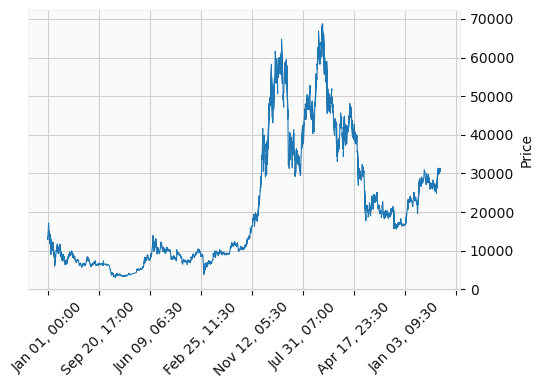

,ot,ct,o,h,l,c,v
count,192515.000000,192515.000000,192515.000000,192515.000000,192515.000000,192515.000000,192515.000000
mean,1601758268915.149414,1601759168914.149414,20804.374937,20859.188950,20747.597860,20804.458859,18593348.551014
std,50129707414.985107,50129707414.985107,16286.196694,16332.128693,16239.010646,16286.211805,29738813.399704
min,1514764800000.000000,1514765699999.000000,3166.110000,3174.780000,3156.260000,3167.070000,0.000000
25%,1558373850000.000000,1558374749999.000000,8040.000000,8063.970000,8013.330000,8040.305000,2592031.715000
50%,1601790300000.000000,1601791199999.000000,12619.530000,12682.770000,12536.730000,12619.560000,7555838.130000
75%,1645185150000.000000,1645186049999.000000,30584.235000,30644.120000,30521.000000,30584.285000,23344278.350000
max,1688505300000.000000,1688506199999.000000,68718.890000,69000.000000,68480.000000,68718.900000,880441840.670000


In [5]:
# Download the dataset for the given interval
raw_ds: DataFrame = utils.get_historic_candlesticks(
    CONFIG["candlesticks_interval"], 
    start=CONFIG["ds_start"],
    end=CONFIG["ds_end"],
)
utils.plot_candlesticks(raw_ds, display_volume=False, figsize=SMALL_FIG_SIZE)
raw_ds.describe()

# Normalized Dataset

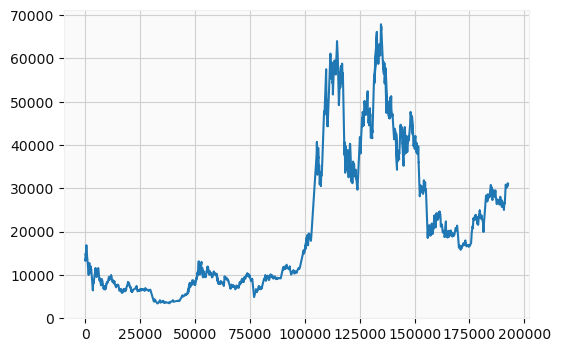

,c
count,192466.000000
mean,20804.105059
std,16285.012791
min,3191.605600
25%,8032.055700
50%,12511.837400
75%,30576.195450
max,67891.094800


In [6]:
# The first step to normalize the dataset is to calculate the simple moving average
sma_ds: DataFrame = raw_ds[["c"]].rolling(CONFIG["sma_window_size"]).mean()
sma_ds.dropna(inplace=True)
fig = plt.figure(figsize=SMALL_FIG_SIZE)
plt.plot(sma_ds["c"])
plt.show()
sma_ds.describe()

SCALED DATASET

Null Values: False

Shape: (192466, 1)

count   192466.000000
mean         0.272220
std          0.251702
min          0.000003
25%          0.074814
50%          0.144054
75%          0.423258
max          1.000000
Name: c, dtype: float64


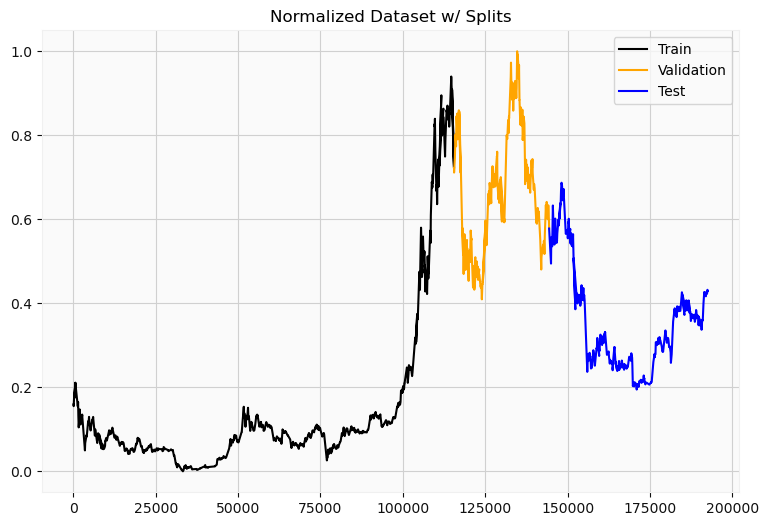

In [7]:
# Calculate the min and max values present in the SMA Dataset
min_val: float = sma_ds["c"].min()
max_val: float = sma_ds["c"].max()
    
# Finally, scale the values and ensure the smallest value in the ds is greater than 0
ds: DataFrame = sma_ds[["c"]].apply(lambda x: (x - min_val) / (max_val - min_val))
ds.loc[ds["c"].nsmallest(1).index, "c"] = ds["c"].nsmallest(2).iloc[-1]
print("SCALED DATASET\n")
print(f"Null Values: {ds.isnull().values.any()}\n")
print(f"Shape: {ds.shape}\n")
print(ds["c"].describe())

# Display how the dataset will be used
raw_train_split: int = int(ds.shape[0]*CONFIG["train_split"])
real_train_split: int = int(raw_train_split * (1 - CONFIG["validation_split"]))
fig = plt.figure(figsize=MEDIUM_FIG_SIZE)
plt.plot(ds["c"].iloc[0:real_train_split], color='black', label="Train")
plt.plot(ds["c"].iloc[real_train_split:raw_train_split], color='orange', label="Validation")
plt.plot(ds["c"].iloc[raw_train_split:], color='blue', label="Test")
plt.title("Normalized Dataset w/ Splits")
plt.legend()
plt.show()

# Training Data

In [8]:
# Init the raw features & labels
features_raw: Union[List[List[float]], ndarray] = []
labels_raw: Union[List[List[float]], ndarray] = []

# Iterate over the normalized ds and build the features & labels
for i in range(CONFIG["input_width"], ds.shape[0]):
    # Append features and labels for as long as there are records
    if i < (ds.shape[0]-CONFIG["output_width"]):
        features_raw.append(ds.iloc[i-CONFIG["input_width"]:i, 0])
        labels_raw.append(ds.iloc[i:i+CONFIG["output_width"], 0])

# Convert the features and labels into np arrays
features = array(features_raw)
labels = array(labels_raw)

In [9]:
# Now that features and labels have been built, apply the splits
train_split: int = int(ds.shape[0] * CONFIG["train_split"])
    
# Initialize the train data
train_x: ndarray = features[:train_split]
train_y: ndarray = labels[:train_split]
    
# Initialize the test data
test_x: ndarray = features[train_split:]
test_y: ndarray = labels[train_split:]
    
# Print a summary of the training data
print("TRAINING DATA\n")
print(f"Train X: {train_x.shape}")
print(f"Train Y: {train_y.shape}")
print(f"Test X: {test_x.shape}")
print(f"Test Y: {test_y.shape}")

TRAINING DATA

Train X: (144349, 128)
Train Y: (144349, 32)
Test X: (47957, 128)
Test Y: (47957, 32)


# Model Build

In [10]:
# If enabled, it will flatten the data from the hidden layers before getting to the output layer
flatten_hidden_layer: bool = False

# Init the model
model = Sequential()

# Add the input layer
model.add(Input(shape=(CONFIG["input_width"],)))

# Build the layers
for i, layer in enumerate(CONFIG["hidden_layers"]):
    # Reshape the input if applies
    if i == 0 and (layer["type"] == "Conv1D" or layer["type"] == "LSTM" or layer["type"] == "BDLSTM" or layer["type"] == "GRU"):
        model.add(Reshape((CONFIG["input_width"],1,)))

    # Dense Layer
    if layer["type"] == "Dense":
        model.add(Dense(layer["units"], activation=layer["activation"]))

    # Conv1D Layer
    elif layer["type"] == "Conv1D":
        flatten_hidden_layer = True
        model.add(Conv1D(layer["filters"], kernel_size=(layer["kernel_size"],), activation=layer["activation"]))

    # MaxPooling1D Layer
    elif layer["type"] == "MaxPooling1D":
        model.add(MaxPooling1D(layer["pool_size"]))

    # LSTM Layer
    elif layer["type"] == "LSTM":
        model.add(LSTM(layer["units"], return_sequences=layer["return_sequences"]))

    # BDLSTM Layer
    elif layer["type"] == "BDLSTM":
        model.add(Bidirectional(LSTM(layer["units"], return_sequences=layer["return_sequences"])))

    # GRU Layer
    elif layer["type"] == "GRU":
        model.add(GRU(layer["units"], return_sequences=layer["return_sequences"]))

# Check if it needs to be flattened
if flatten_hidden_layer:
    model.add(Flatten())

# Add the output layer
model.add(Dense(CONFIG["output_width"]))

# Print a summary of the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 128, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          328192    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
Total params: 1,432,352
Trainable params: 1,432,352
Non-trainable params: 0
_________________________________________________________________


### Learning Rate

The optimizer can handle static or dynamic learning rate values. In this notebook, providing -1 will initialize the selected optimizer with an Inverse Time Decay Learning Rate Schedule.

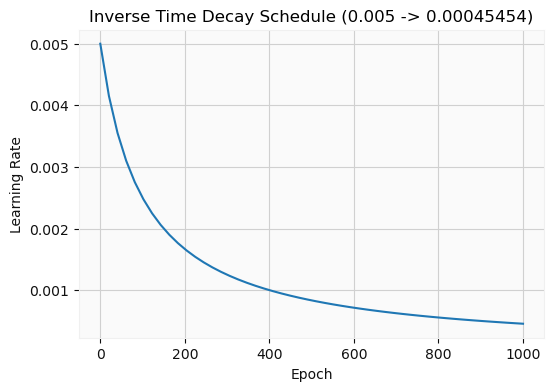

In [11]:
# Initialize the inverse time decay schedule and display it
initial_learning_rate: float = 0.005
inverse_time_decay_lr_schedule: InverseTimeDecay = InverseTimeDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10,
    decay_rate=0.1,
    staircase=False
)
step = linspace(0, CONFIG["max_epochs"])
lr = inverse_time_decay_lr_schedule(step)
fig = plt.figure(figsize=SMALL_FIG_SIZE)
plt.plot(step, lr)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title(f"Inverse Time Decay Schedule ({initial_learning_rate} -> {str(lr[-1].numpy())[:10]})")
plt.show()

In [12]:
# Initialize the learning rate that will be given to the optimizer
learning_rate: Union[InverseTimeDecay, float] = inverse_time_decay_lr_schedule if CONFIG["learning_rate"] == "-1" else float(CONFIG["learning_rate"])

### Optimizer

In [13]:
# Initialize the Optimizer based on the config
optimizer: Union[Adam, RMSprop, SGD]
if CONFIG["optimizer"] == "adam":
    optimizer = Adam(learning_rate)
elif CONFIG["optimizer"] == "rmsprop":
    optimizer = RMSprop(learning_rate)
elif CONFIG["optimizer"] == "sgd":
    optimizer = SGD(learning_rate)

### Compilation

In [14]:
model.compile(
    optimizer=optimizer,
    loss=MeanAbsoluteError() if CONFIG["loss_function"] == "mean_absolute_error" else MeanSquaredError(),
    metrics=[ MeanSquaredErrorMetric() if CONFIG["loss_function"] == "mean_absolute_error" else MeanAbsoluteErrorMetric() ]
)

# Training

In [15]:
# Initialize the early stopping callback function
early_stopping = EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=CONFIG["early_stopping_patience"],
    restore_best_weights=CONFIG["restore_best_weights"]
)

In [16]:
# Train the model
history_object: History = model.fit(
    train_x,
    train_y,
    validation_split=CONFIG["validation_split"],
    epochs=CONFIG["max_epochs"],
    shuffle=CONFIG["shuffle_training_data"],
    callbacks=[ early_stopping ],
    batch_size=CONFIG["batch_size"]
)

Epoch 1/1000
226/226 [==============================] - 58s 214ms/step - loss: 0.0244 - mean_squared_error: 0.0068 - val_loss: 0.0137 - val_mean_squared_error: 2.9251e-04
Epoch 2/1000
226/226 [==============================] - 50s 220ms/step - loss: 0.0028 - mean_squared_error: 3.1204e-05 - val_loss: 0.0061 - val_mean_squared_error: 7.6754e-05
Epoch 3/1000
226/226 [==============================] - 52s 229ms/step - loss: 0.0024 - mean_squared_error: 1.5621e-05 - val_loss: 0.0060 - val_mean_squared_error: 7.2306e-05
Epoch 4/1000
226/226 [==============================] - 51s 225ms/step - loss: 0.0019 - mean_squared_error: 1.2858e-05 - val_loss: 0.0070 - val_mean_squared_error: 8.1575e-05
Epoch 5/1000
226/226 [==============================] - 51s 227ms/step - loss: 0.0017 - mean_squared_error: 1.1814e-05 - val_loss: 0.0071 - val_mean_squared_error: 8.5126e-05
Epoch 6/1000
226/226 [==============================] - 52s 230ms/step - loss: 0.0016 - mean_squared_error: 1.0951e-05 - val_loss

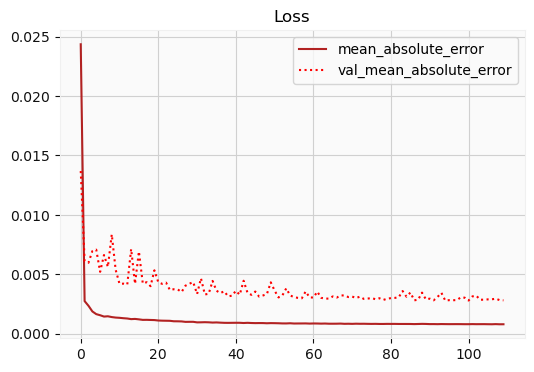

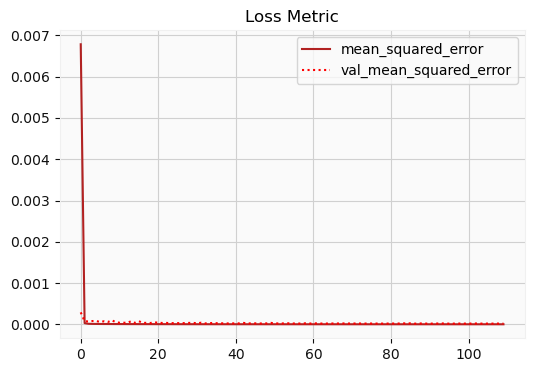

In [17]:
# Display the learning curves
def display_learning_curve(title: str, loss_id: ILossFunctionID, loss_curve: List[float], val_loss_curve: List[float]) -> None:
    fig = plt.figure(figsize=SMALL_FIG_SIZE)
    plt.plot(loss_curve, color='firebrick', label=loss_id)
    plt.plot(val_loss_curve, color='red', linestyle='dotted', label=f"val_{loss_id}")
    plt.title(title)
    plt.legend()
    plt.show()

# Display the loss history
display_learning_curve("Loss", CONFIG["loss_function"], history_object.history["loss"], history_object.history["val_loss"])

# Display the loss metric history
metric_id: ILossFunctionID = "mean_squared_error" if CONFIG["loss_function"] == "mean_absolute_error" else "mean_absolute_error"
display_learning_curve("Loss Metric", metric_id, history_object.history[metric_id], history_object.history[f"val_{metric_id}"])

# Test Dataset Evaluation

In [18]:
# Predict the entire test dataset
preds: List[List[float]] = model.predict(test_x, verbose=0).tolist()

In [19]:
# Evaluate the test dataset directly with the loss/metric functions
print(f"mean_absolute_error: {MeanAbsoluteErrorMetric()(preds, test_y):.10f}")
print(f"mean_squared_error: {MeanSquaredErrorMetric()(preds, test_y):.10f}")

mean_absolute_error: 0.0011871037
mean_squared_error: 0.0000044910


# Prediction Samples

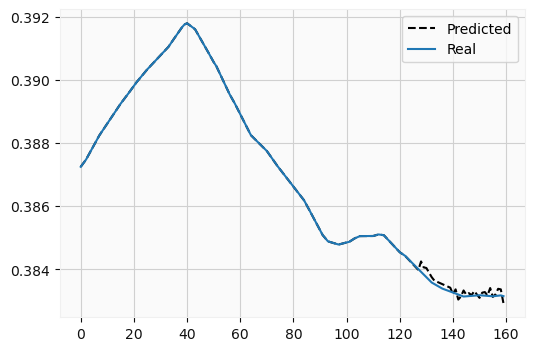

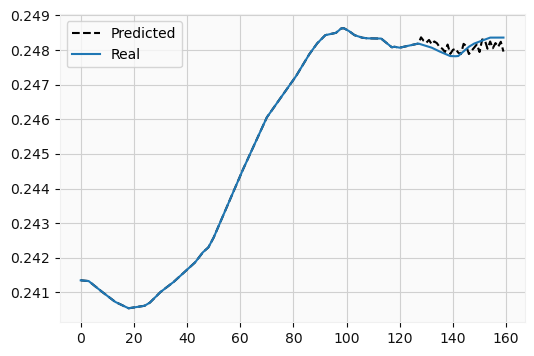

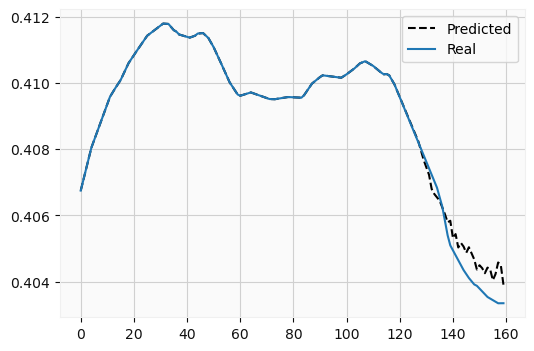

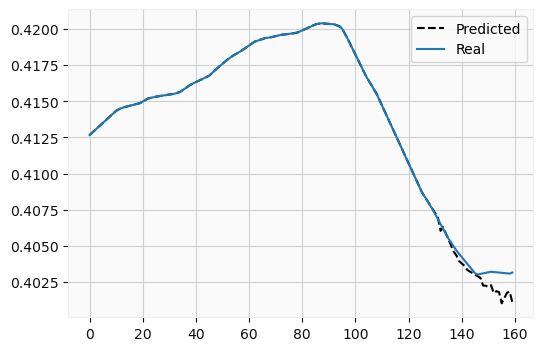

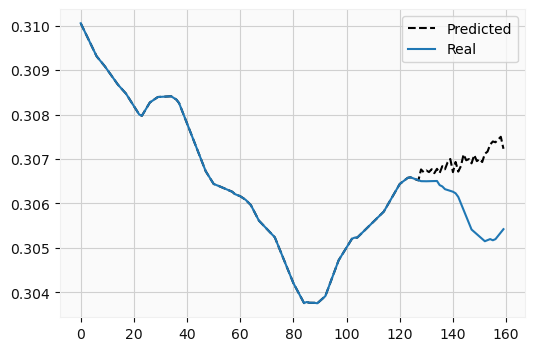

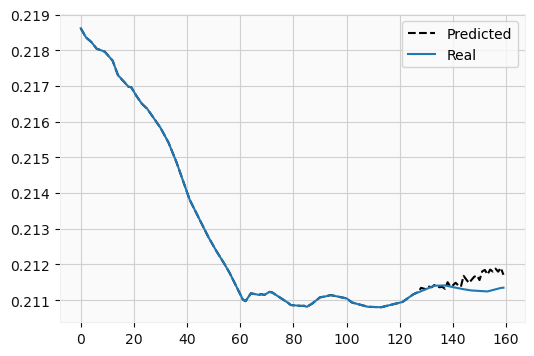

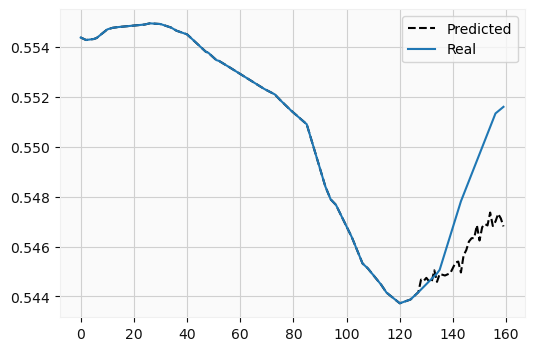

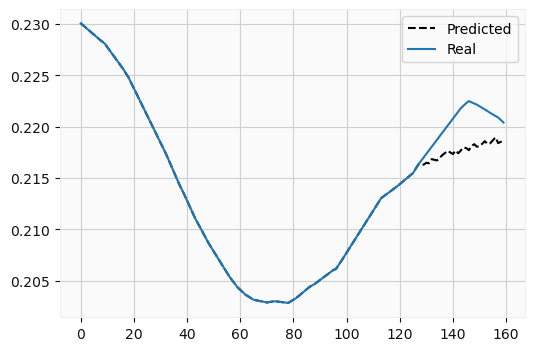

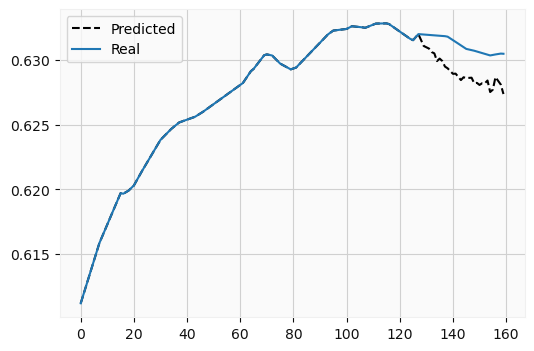

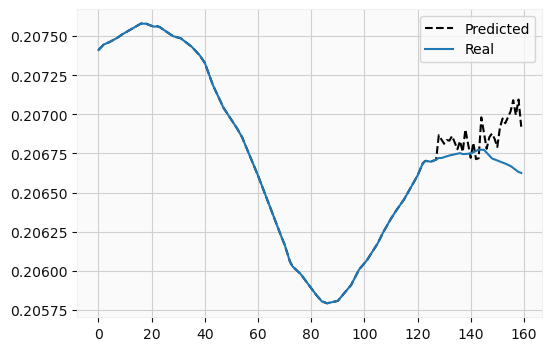

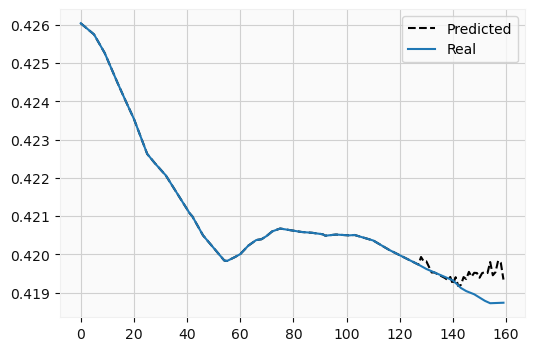

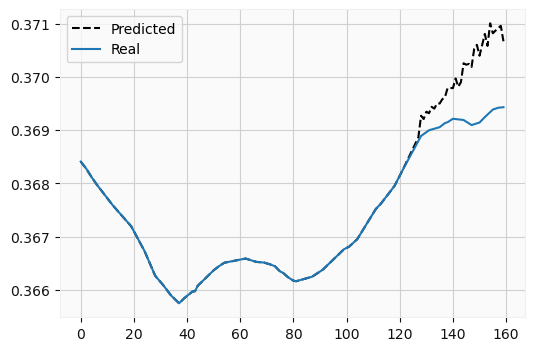

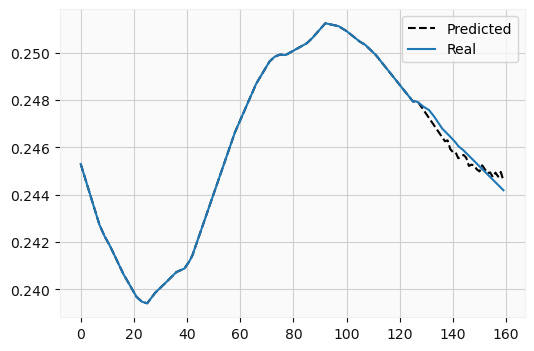

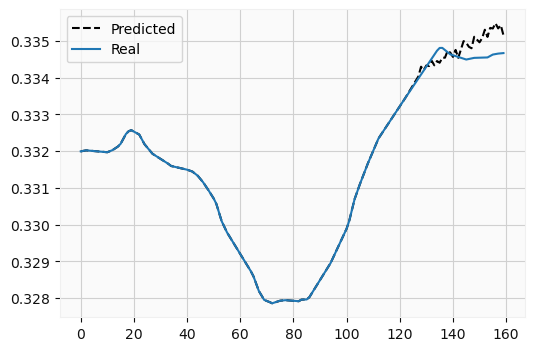

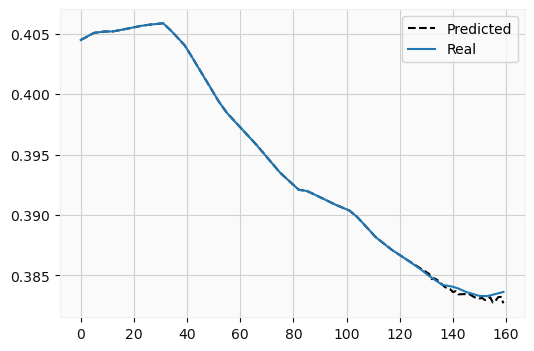

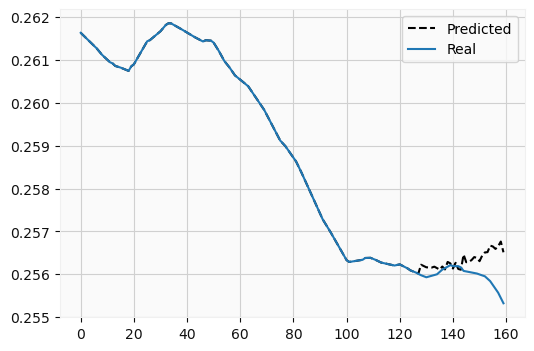

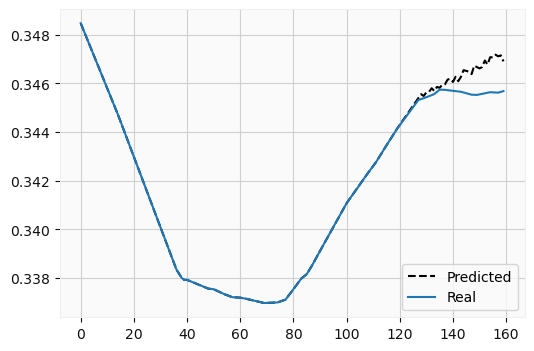

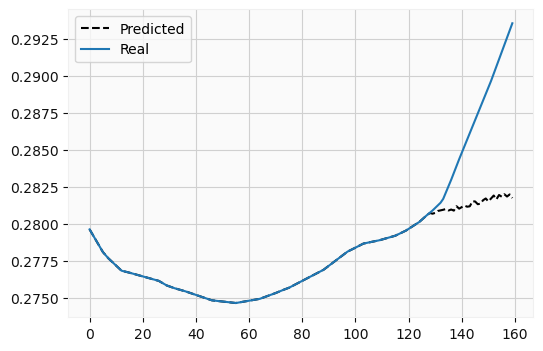

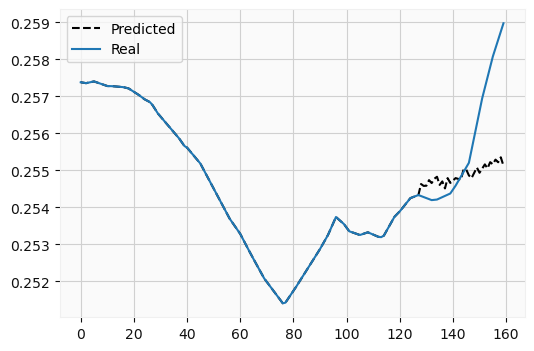

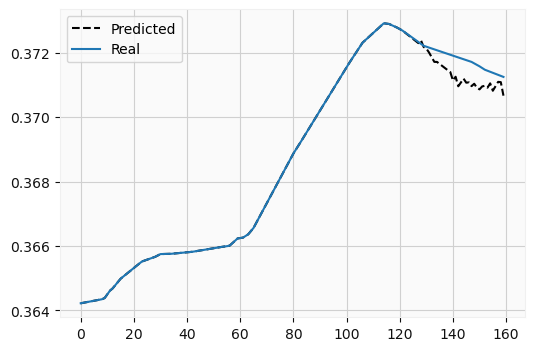

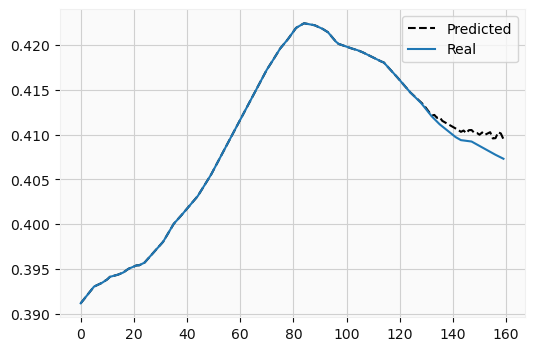

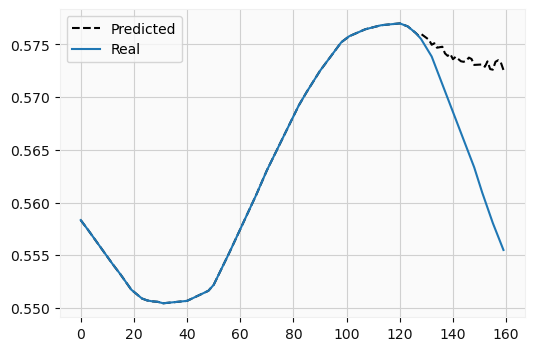

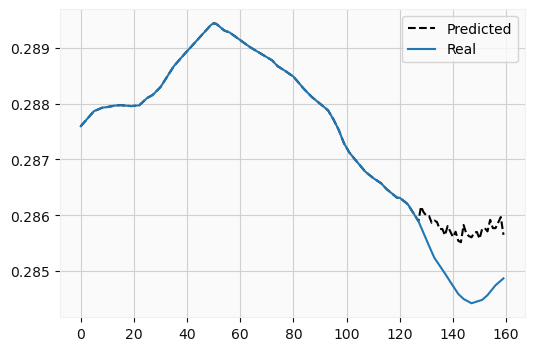

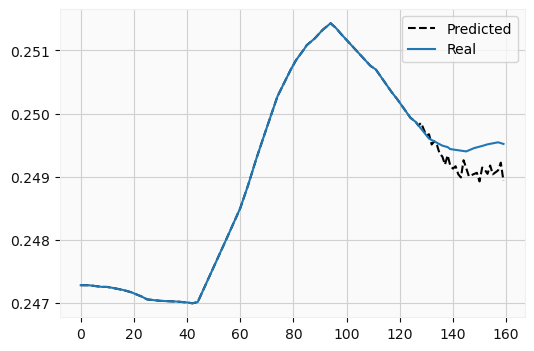

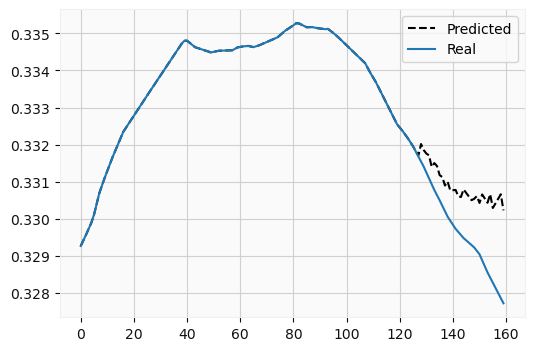

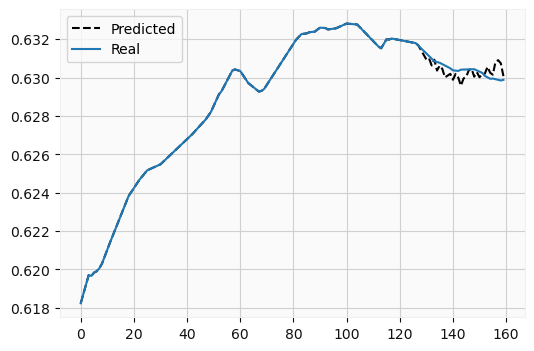

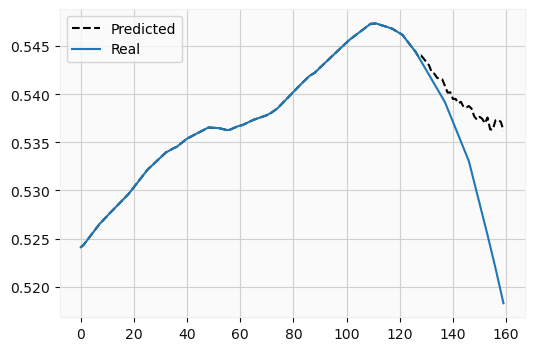

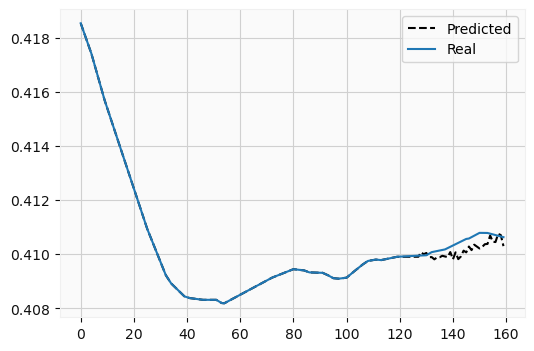

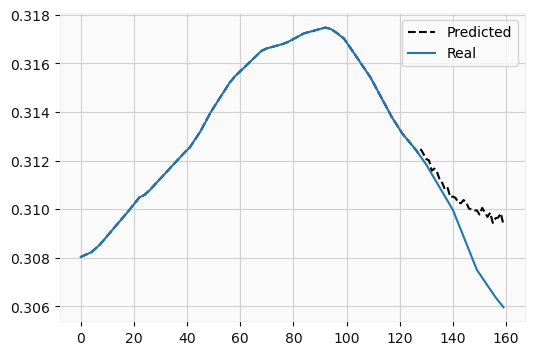

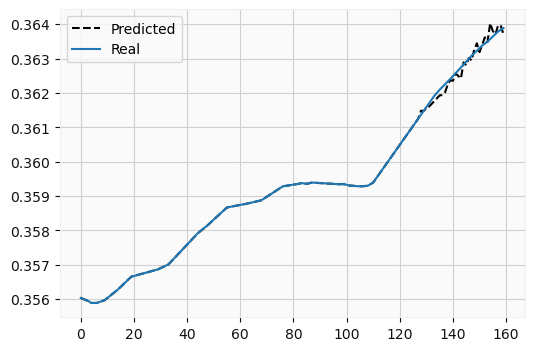

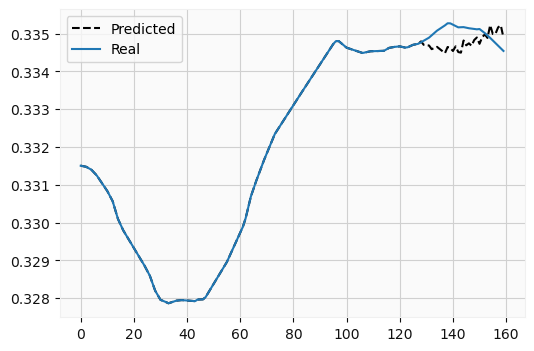

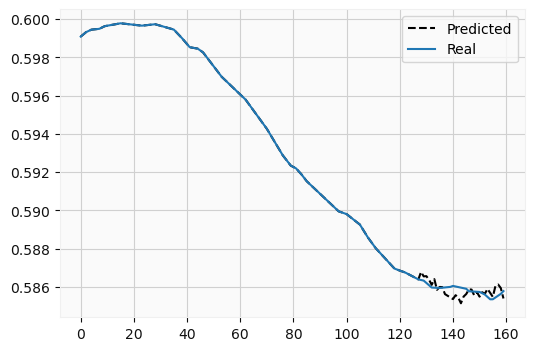

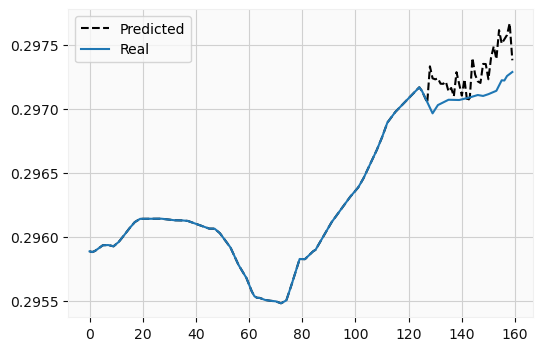

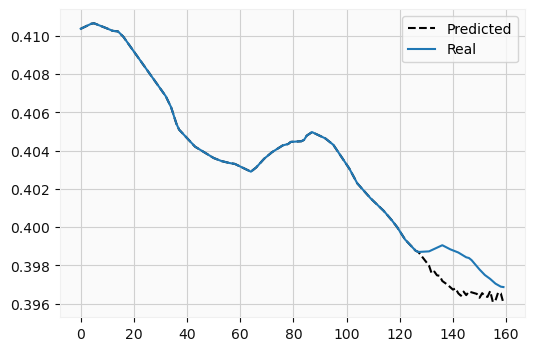

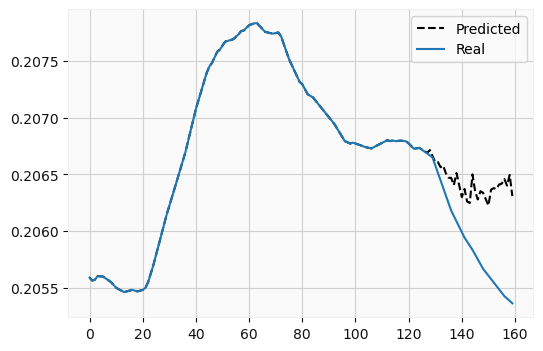

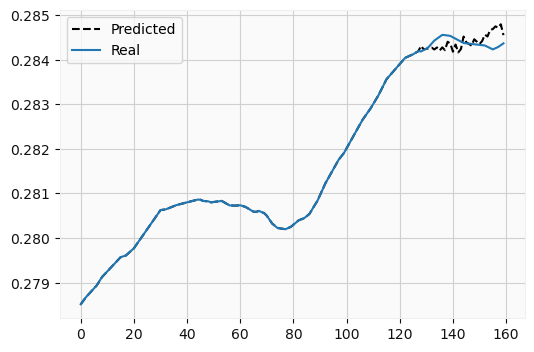

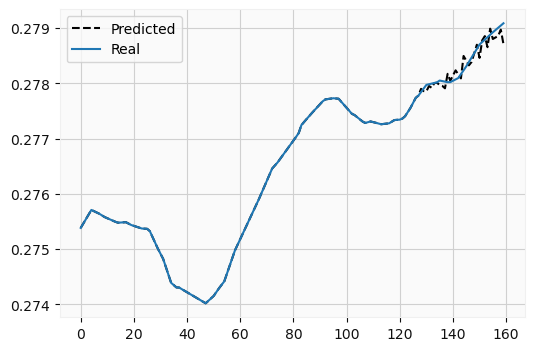

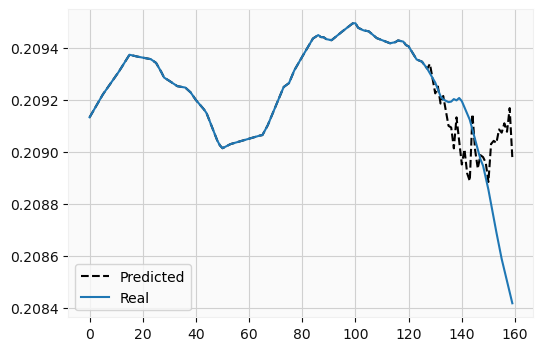

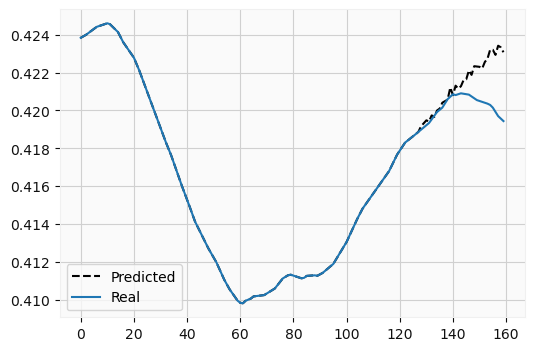

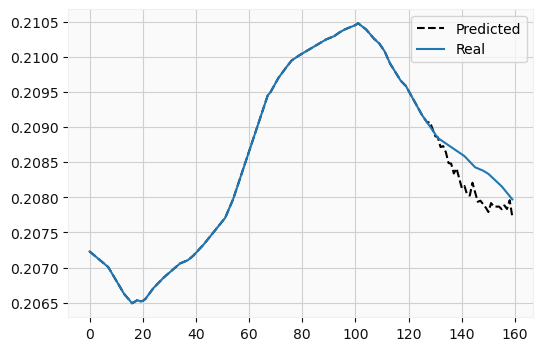

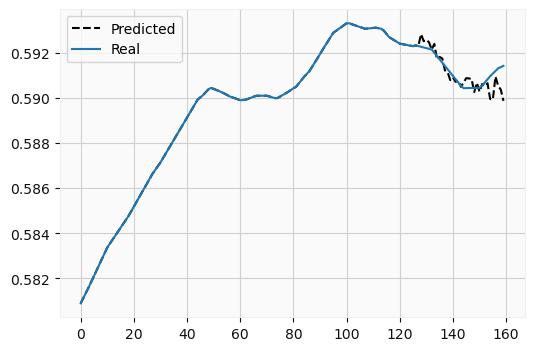

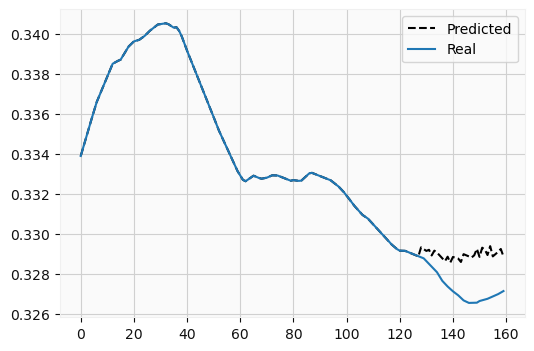

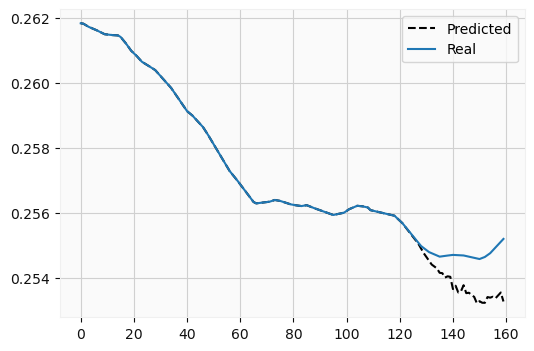

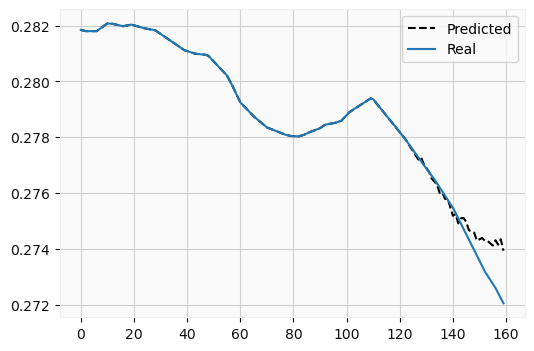

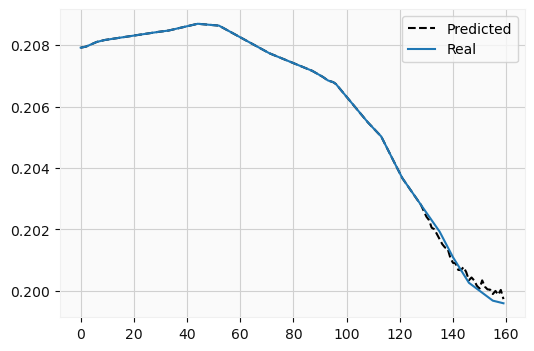

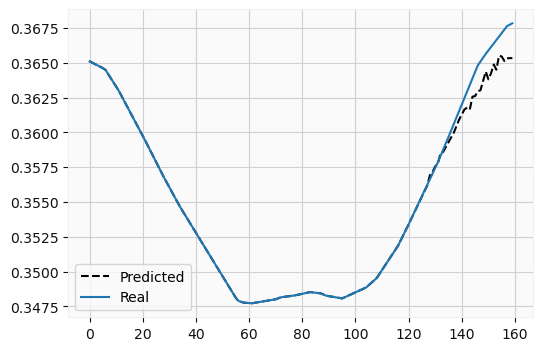

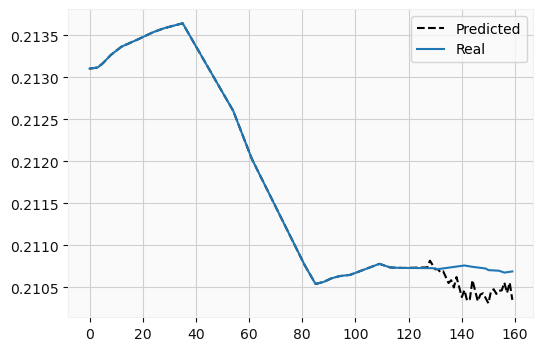

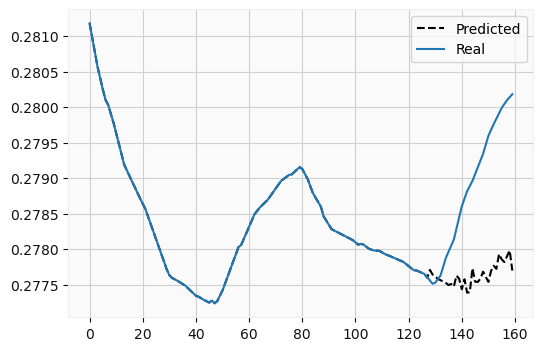

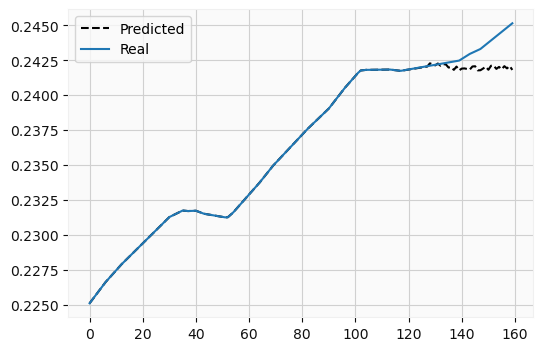

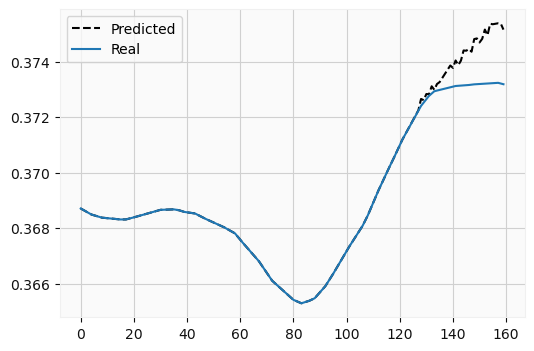

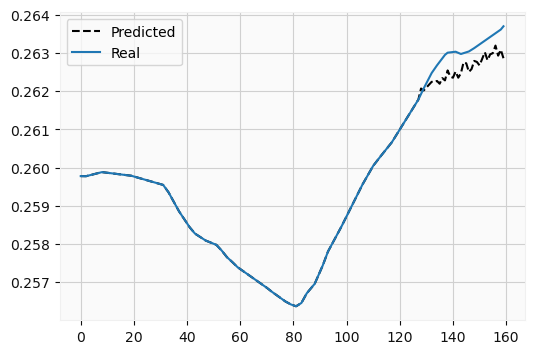

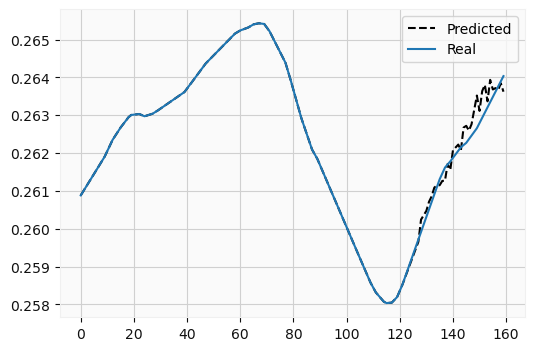

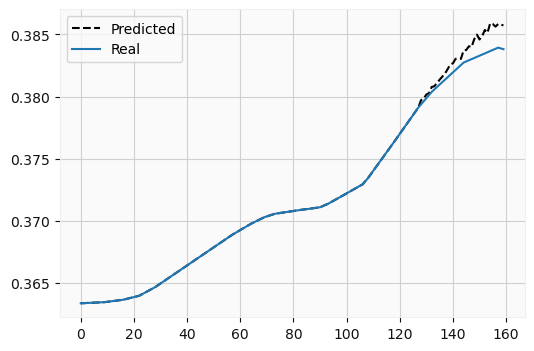

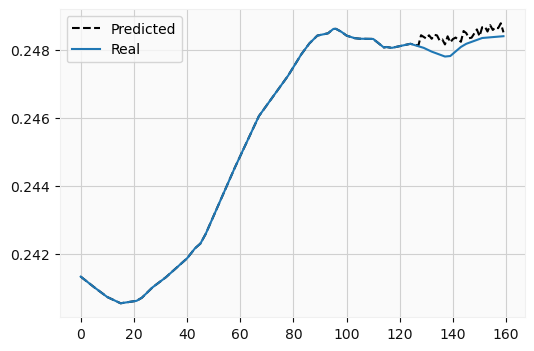

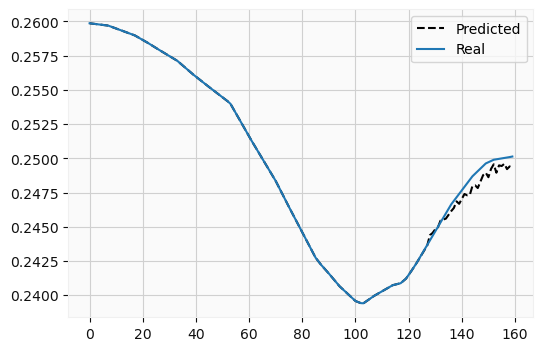

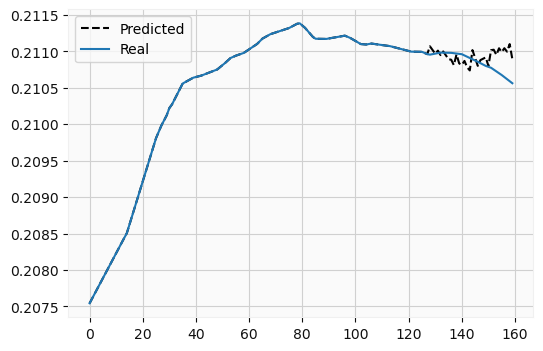

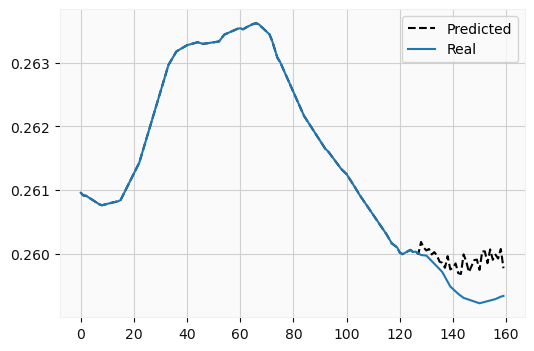

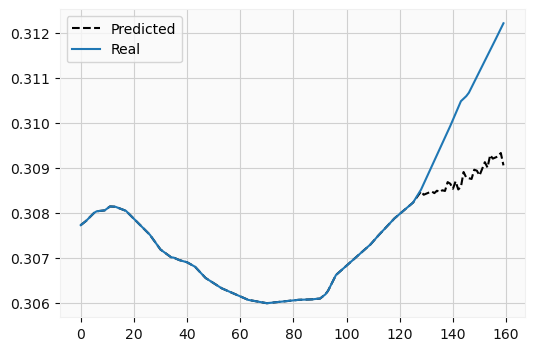

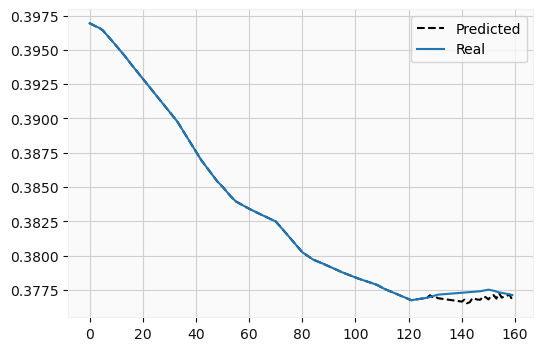

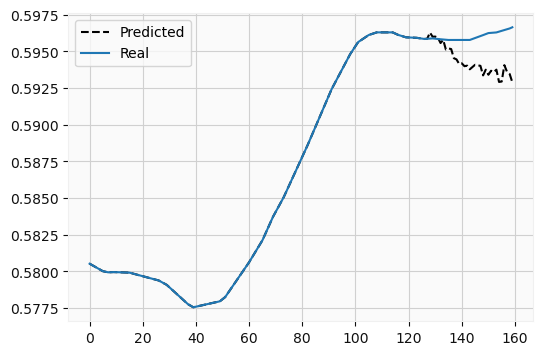

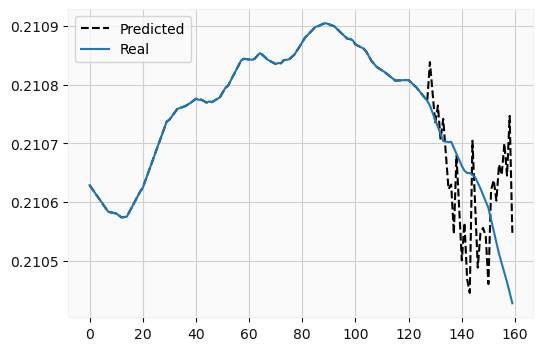

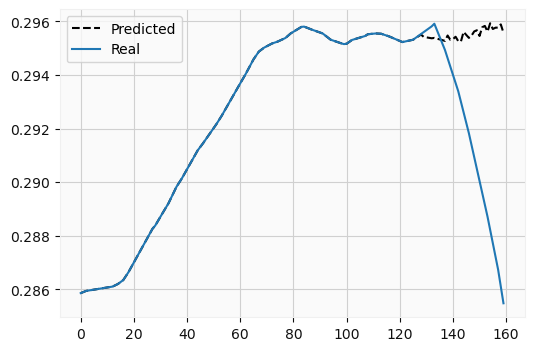

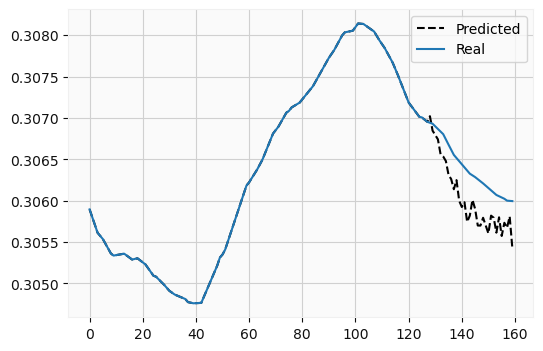

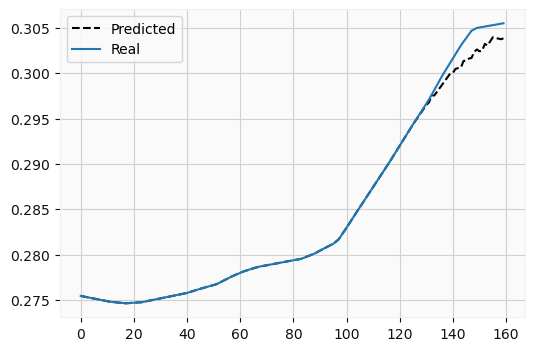

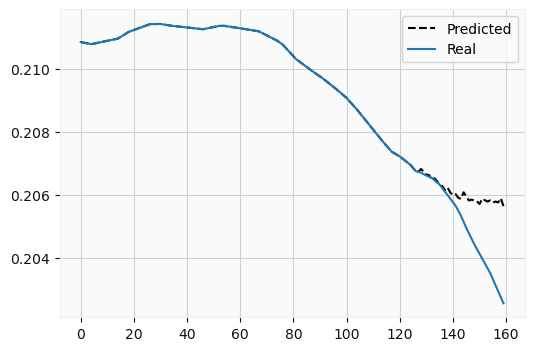

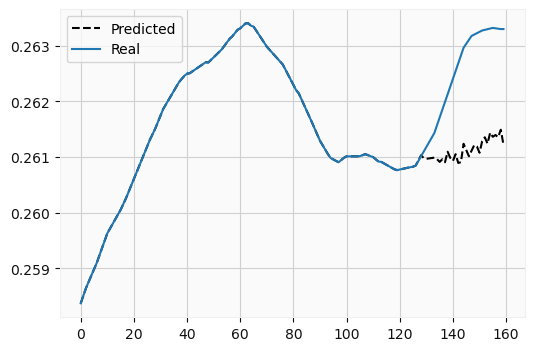

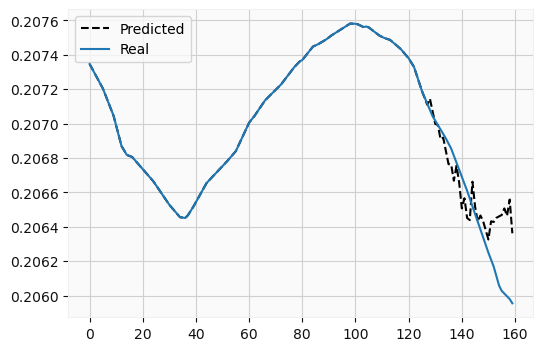

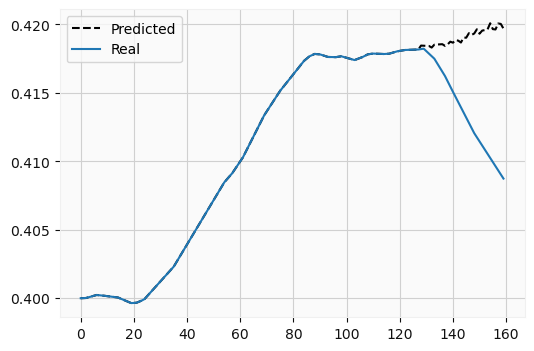

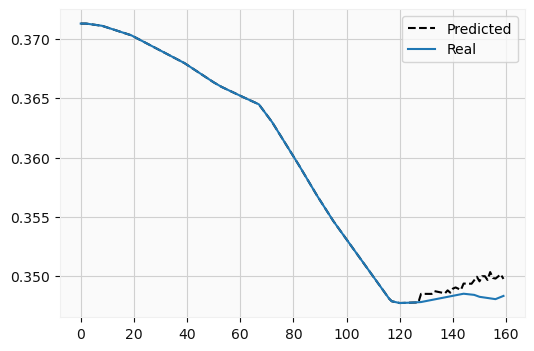

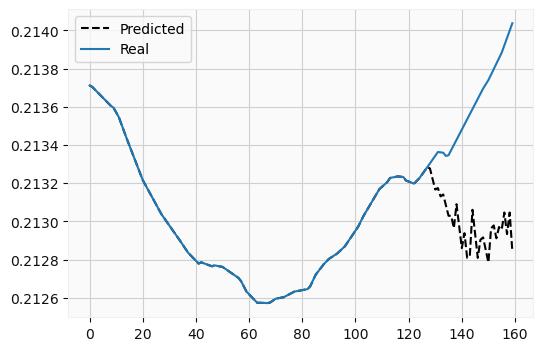

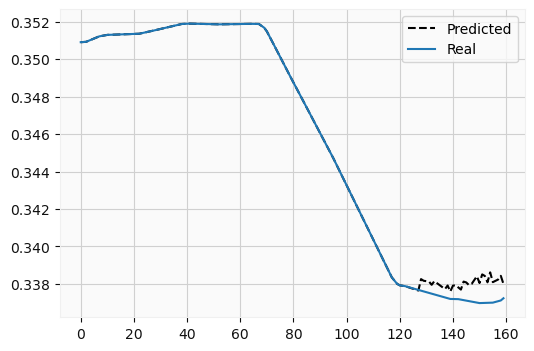

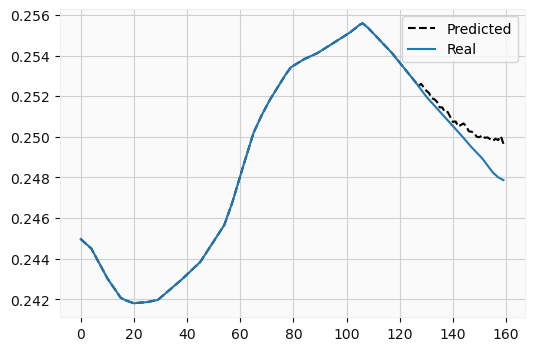

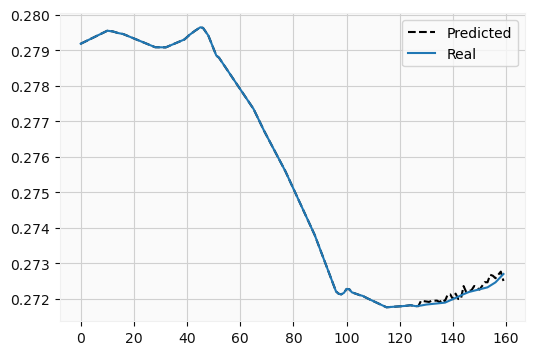

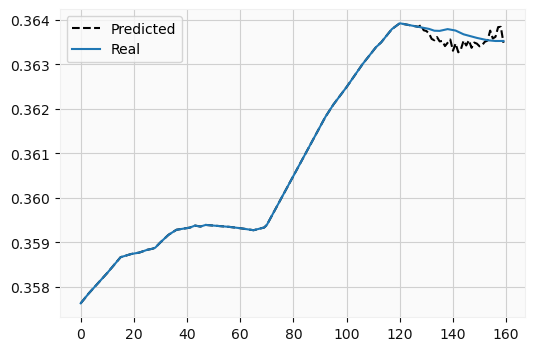

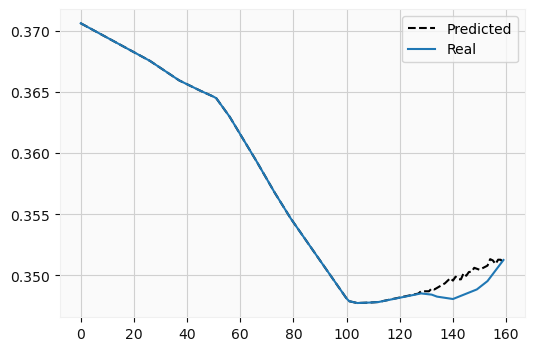

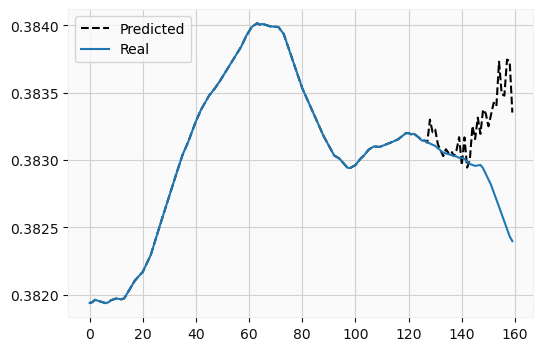

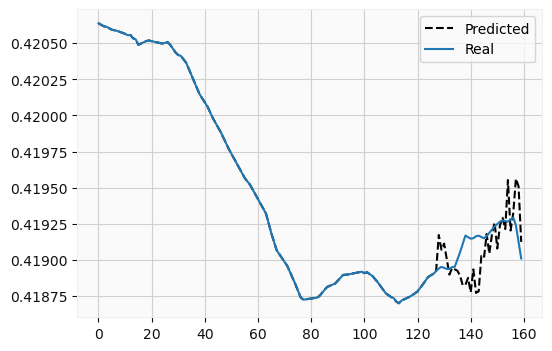

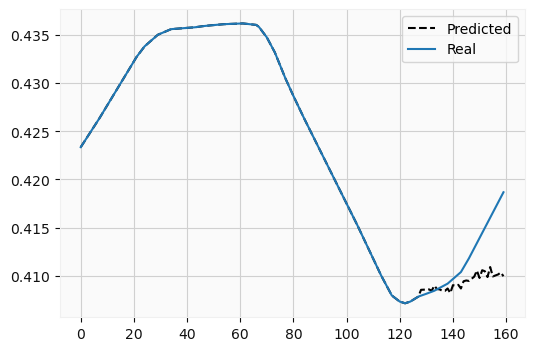

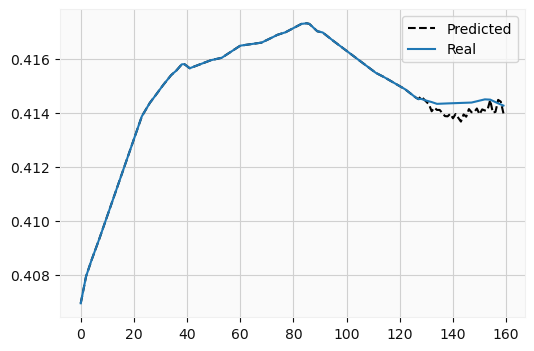

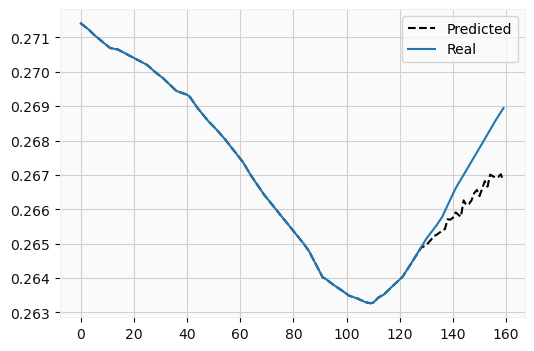

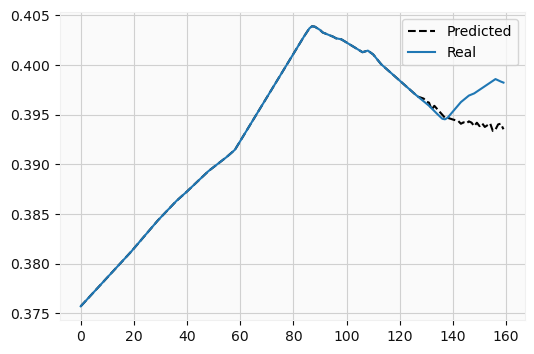

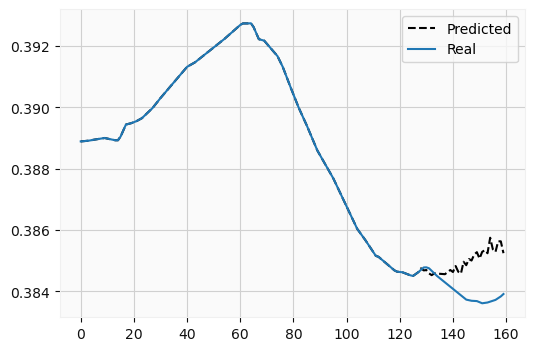

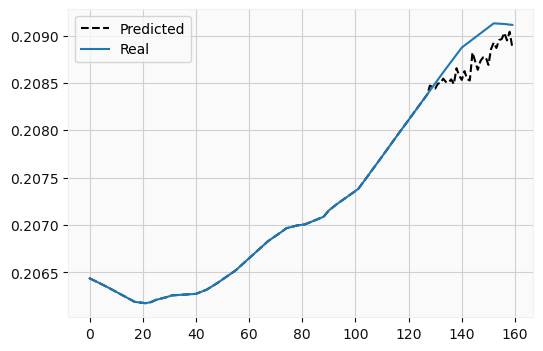

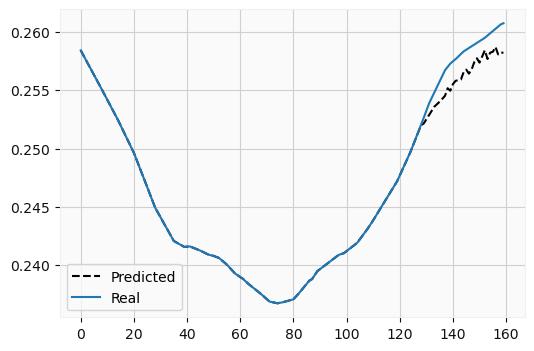

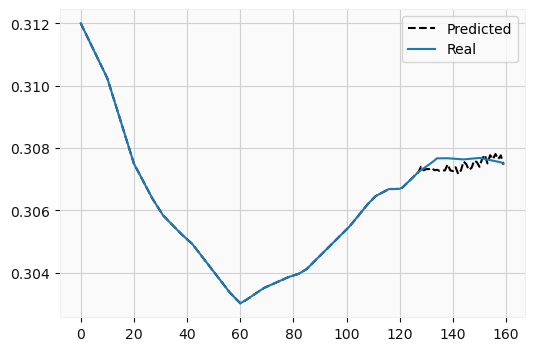

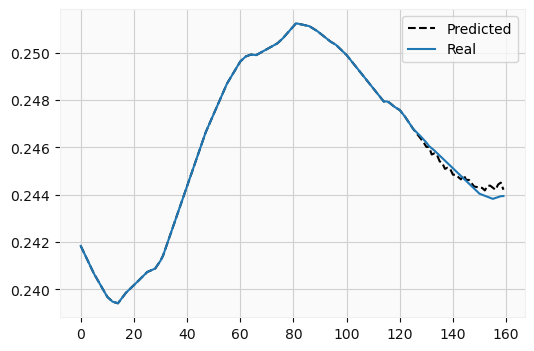

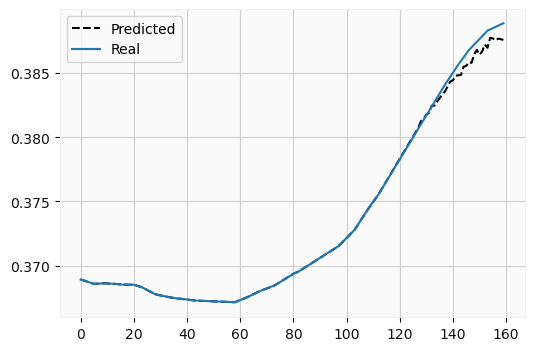

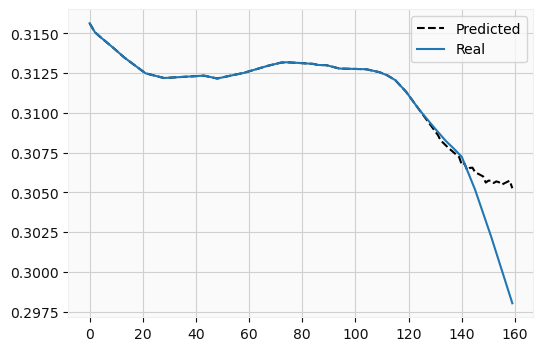

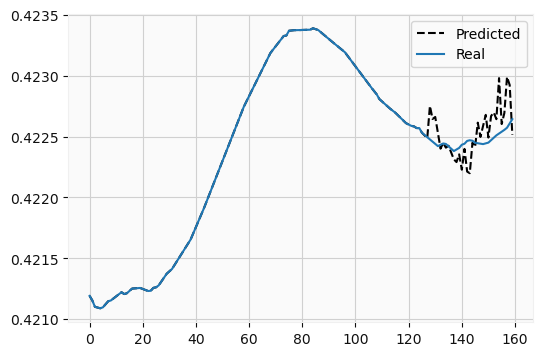

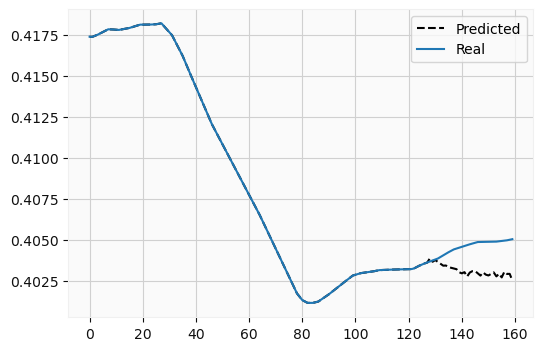

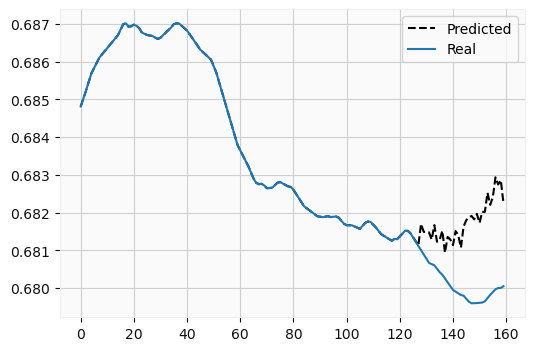

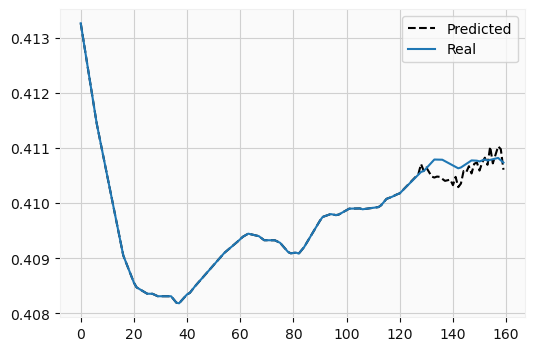

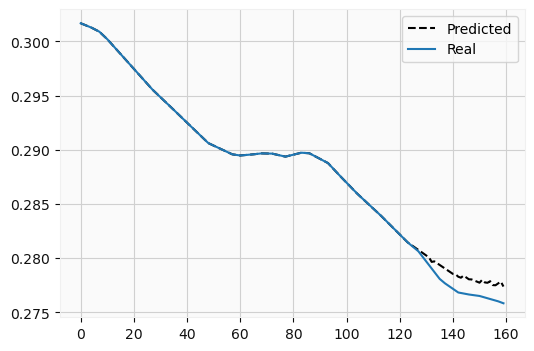

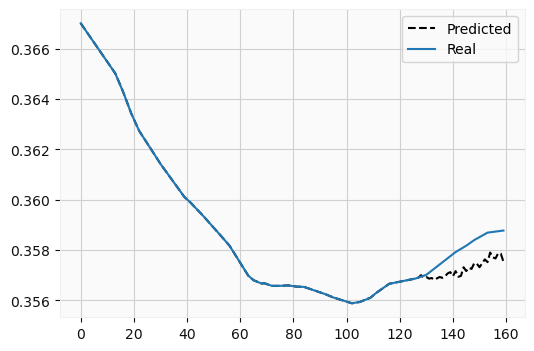

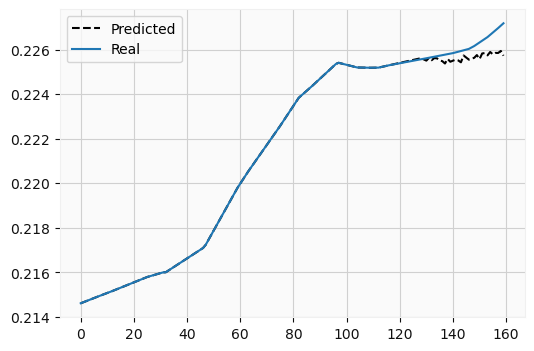

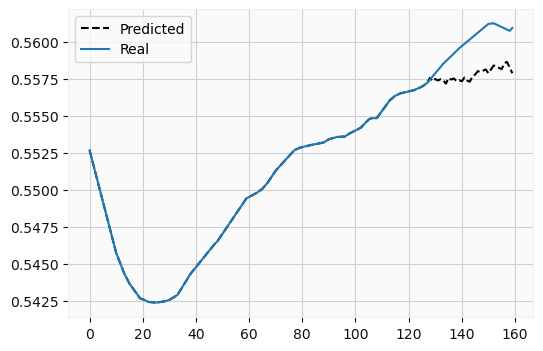

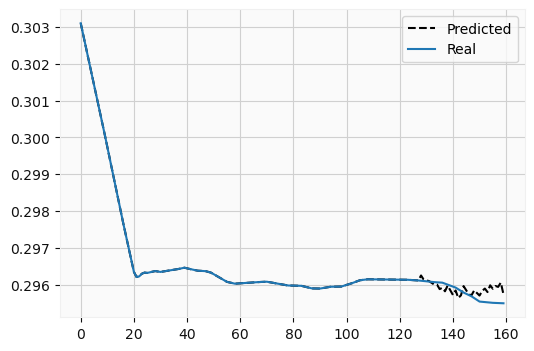

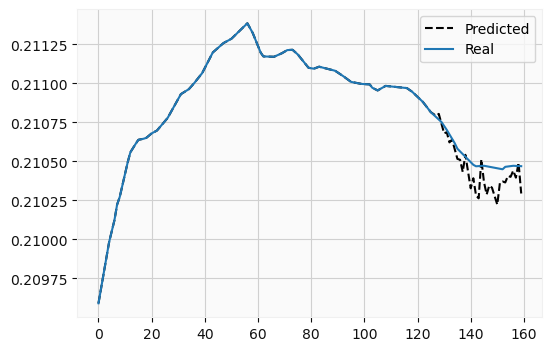

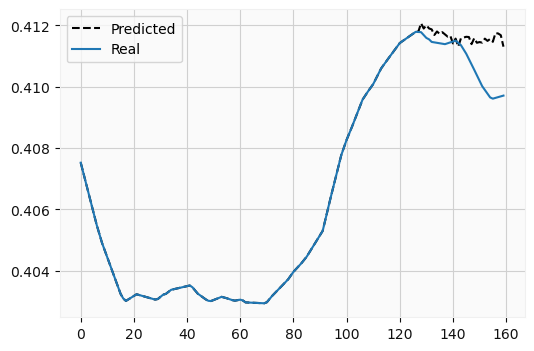

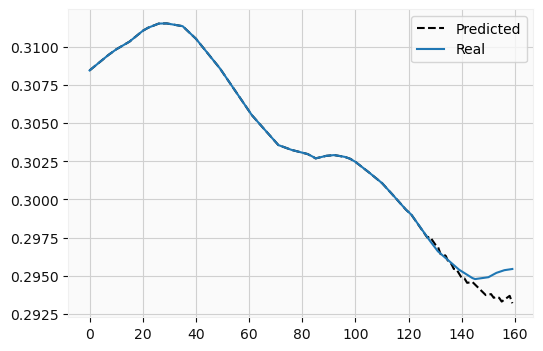

In [20]:
for _ in range(CONFIG["prediction_samples_limit"]):
    # Init the random index
    random_index: int = randint(0, len(preds) - 1)
        
    # Display the sample=
    fig = plt.figure(figsize=SMALL_FIG_SIZE)
    plt.plot(test_x[random_index].tolist()+preds[random_index], color='black', linestyle='dashed', label="Predicted")
    plt.plot(test_x[random_index].tolist()+test_y[random_index].tolist(), label="Real")
    plt.legend()
    plt.show()